In [1]:
from qcomp import *

# State Generating Circuits

### Bell States $\ket{\Phi^+},\ket{\Phi^-},\ket{\Psi^+},\ket{\Psi^-}$

In [2]:
c = Circuit(2, 1)
c.add_gate(HGate(), [0])
c.add_gate(XGate(), [1], [0])
c.draw()

sim = Simulator(c)
sim.run()

q0   -H--●-
q1   ----X-

|00⟩ ---> 0.7071|00⟩ + 0.7071|11⟩


In [3]:
c = Circuit(2, 0)
c.add_gate(XGate(), [0])
c.add_gate(HGate(), [0])
c.add_gate(XGate(), [1], [0])
c.draw()

sim = Simulator(c)
sim.run()

q0   -X--H--●-
q1   -------X-

|00⟩ ---> 0.7071|00⟩ - 0.7071|11⟩


In [4]:
c = Circuit(2, 0)
c.add_gate(XGate(), [1])
c.add_gate(HGate(), [0])
c.add_gate(XGate(), [1], [0])
c.draw()

sim = Simulator(c)
sim.run()

q0   ----H--●-
q1   -X-----X-

|00⟩ ---> 0.7071|01⟩ + 0.7071|10⟩


In [6]:
c = Circuit(2, 0)
c.add_gate(XGate(), [0])
c.add_gate(XGate(), [1])
c.add_gate(HGate(), [0])
c.add_gate(XGate(), [1], [0])
c.draw()

sim = Simulator(c)
sim.run()

q0   -X-----H--●-
q1   ----X-----X-

|00⟩ ---> 0.7071|01⟩ - 0.7071|10⟩


### $\ket{W_n}$ state

In [5]:
N = 10
c = Circuit(N, 0)

def theta(n):
    return 2*np.arccos(1/np.sqrt(n))

c.add_gate(RYGate(theta(N)), [0])
for i in range(1,N-1):
    c.add_gate(RYGate(theta(N-i)), [i], [i-1])

for i in range(1, N):
    c.add_gate(XGate(), [N-i], [N-i-1])
c.add_gate(XGate(), [0])

c.draw()
sim = Simulator(c)
sim.run()



q0   -RY(0.8π)--●-------------------------------------------------------------------------------------------------------------●--X-
q1   -----------RY(0.78π)--●-----------------------------------------------------------------------------------------------●--X----
q2   ----------------------RY(0.77π)--●---------------------------------------------------------------------------------●--X-------
q3   ---------------------------------RY(0.75π)--●-------------------------------------------------------------------●--X----------
q4   --------------------------------------------RY(0.73π)--●-----------------------------------------------------●--X-------------
q5   -------------------------------------------------------RY(0.7π)--●----------------------------------------●--X----------------
q6   -----------------------------------------------------------------RY(0.67π)--●--------------------------●--X-------------------
q7   -----------------------------------------------------------------------

### GHZ state

In [6]:
N = 10
c = Circuit(N, 0)

c.add_gate(HGate(), [0])
for i in range(1, N):
    c.add_gate(XGate(), [i], [i-1])

c.draw()
sim = Simulator(c)
sim.run()



q0   -H--●-------------------------
q1   ----X--●----------------------
q2   -------X--●-------------------
q3   ----------X--●----------------
q4   -------------X--●-------------
q5   ----------------X--●----------
q6   -------------------X--●-------
q7   ----------------------X--●----
q8   -------------------------X--●-
q9   ----------------------------X-

|0000000000⟩ ---> 0.7071|0000000000⟩ + 0.7071|1111111111⟩


# Protocols

### Quantum Teleportation

In [7]:
c = Circuit(3, 2)
# entangle q1 and q2
c.add_gate(HGate(), [1])
c.add_gate(XGate(), [2], [1])

# teleportation protocol
c.add_gate(XGate(), [1], [0])
c.add_gate(HGate(), [0])
c.measure([0], [0])
c.measure([1], [1])

c.add_gate(XGate(), [2], [1])
c.add_gate(ZGate(), [2], [0])

c.draw()

# run protocol for choice of psi
psi = (1, 1)
sim = Simulator(c)
sim.reset_state(np.kron(psi, (1,0,0,0)))
print(f'|ψ⟩ = {Visualizer.state_vector(psi / np.linalg.norm(psi))}')
sim.run()

q0   -------●--H--\Z/----------●-
q1   -H--●--X----------\Z/--●--|-
q2   ----X------------------X--Z-

|ψ⟩ = 0.7071|0⟩ + 0.7071|1⟩
0.7071|000⟩ + 0.7071|100⟩ ---> 0.7071|100⟩ + 0.7071|101⟩


### Superdense Coding

In [8]:
b1, b2 = 0, 1
print(f'Encoded bits: [{b1}, {b2}]')
c = Circuit(2, 2)
c.add_gate(HGate(), [0])
c.add_gate(XGate(), [1], [0])

if b2:
    c.add_gate(XGate(), [0])
if b1:
    c.add_gate(ZGate(), [0])

c.add_gate(XGate(), [1], [0])
c.add_gate(HGate(), [0])

c.measure([0], [0])
c.measure([1], [1])

c.draw()

sim = Simulator(c)
sim.run()
print(f'Decoded bits: [{sim.cbits[0]}, {sim.cbits[1]}]')

Encoded bits: [0, 1]
q0   -H--●--X--●--H--\Z/------
q1   ----X-----X----------\Z/-

|00⟩ ---> |01⟩
Decoded bits: [0, 1]


### Deutsch-Josza Algorithm

Promise: $f: \{0,1\}^n \rightarrow \{0,1\}$ is either balanced or constant. $f$ is represented with a $2^n$-bit string of the outputs corresponding to each input.

Begin by constructing a unitary matrix $U_f$ such that, for $x\in\{0,1\}^n$ and $y\in\{0,1\}$, we have $U_f(\ket{x}\otimes\ket{y})=\ket{x}\otimes\ket{y\oplus f(x)}$

The proposed circuit gives a state with a 100% probability on the result $\ket{0\cdots0}$ if and only if $f$ is constant, and a 0% probability if and only if $f$ is balanced.

In [9]:
def deutsch_oracle(f):
    dim = 2*len(f)  # 2**(n+1)
    U = np.zeros((dim,dim), dtype = np.uint8)
    for z in range(dim):
        x = z >> 1
        y = z & 1
        y2 = y ^ f[x]
        z2 = (x << 1) | y2
        U[z2, z] = 1
    return U

In [10]:
n = 10
constant = np.ones(2**n, dtype = int)#*0 # uncomment for constant zeros instead
balanced = np.ones(2**n, dtype = int)
balanced[:2**(n-1)] = 0
np.random.shuffle(balanced) # will generate a random balanced array

# defining U_f
f = constant
print("f = " + str(f) + "\n")
Uf = Gate("Uf", deutsch_oracle(f), n_qbits = n + 1)

c = Circuit(n+1, n)
c.add_gate(XGate(), [n])
c.add_gate(HGate(n+1), np.arange(n+1))
c.add_gate(Uf, np.arange(n+1))
c.add_gate(HGate(n), np.arange(n))

c.draw()

sim = Simulator(c)
sim.run()

zerozero = np.zeros(2**(n+1))
zerozero[0] = 1
zeroone = np.zeros(2**(n+1))
zeroone[1] = 1
prob_zero = np.abs(zerozero.T @ sim.state)**2 + np.abs(zeroone.T @ sim.state)**2
print("\nP(|" + "0"*n + "⟩) = P(|" + "0"*(n+1) + "⟩) + P(|" + "0"*n + "1⟩) = " + str(prob_zero))
if np.isclose(prob_zero, 0, atol = 1e-5):
    print("f is balanced")
elif np.isclose(prob_zero, 1, atol = 1e-5):
    print("f is constant")

f = [1 1 1 ... 1 1 1]

q0   ----H--Uf--H-
q1   ----H--Uf--H-
q2   ----H--Uf--H-
q3   ----H--Uf--H-
q4   ----H--Uf--H-
q5   ----H--Uf--H-
q6   ----H--Uf--H-
q7   ----H--Uf--H-
q8   ----H--Uf--H-
q9   ----H--Uf--H-
q10  -X--H--Uf----

|00000000000⟩ ---> 0.7071|00000000000⟩ + 0.7071|00000000001⟩ - 0.0000|00000001000⟩ - 0.0000|00000010000⟩ + 0.0000|00000010001⟩ - 0.0000|00000011001⟩ - 0.0000|00000100000⟩ + 0.0000|00000100001⟩ - 0.0000|00000101001⟩ - 0.0000|00000110000⟩ + 0.0000|00000110001⟩ - 0.0000|00000111001⟩ - 0.0000|00001000000⟩ + 0.0000|00001000001⟩ - 0.0000|00001001001⟩ - 0.0000|00001010000⟩ + 0.0000|00001010001⟩ - 0.0000|00001011001⟩ - 0.0000|00001100000⟩ + 0.0000|00001100001⟩ - 0.0000|00001101001⟩ - 0.0000|00001110000⟩ + 0.0000|00001110001⟩ - 0.0000|00001111001⟩ - 0.0000|00010000000⟩ + 0.0000|00010000001⟩ - 0.0000|00010001001⟩ - 0.0000|00010010000⟩ + 0.0000|00010010001⟩ - 0.0000|00010011001⟩ - 0.0000|00010100000⟩ + 0.0000|00010100001⟩ - 0.0000|00010101001⟩ - 0.0000|00010110000⟩ + 

### Simon's Problem

$f: \{0,1\}^N \rightarrow \{0,1\}^{N-1}$ is a 2-1 function, that is, for every output $y\in\{0,1\}^{N-1}$ there are exactly 2 inputs $x_1,x_2\in\{0,1\}^N$ such that $f(x_1)=f(x_2)=y$.

If $x_1 = x$ and $x_2 = x\oplus s$ for all outputs $y$ and a fixed $s\in\{0,1\}^N$, determine $s$.

Begin by constructing a unitary matrix $U_f$ such that, for $x\in\{0,1\}^N$ and $y\in\{0,1\}^{N-1}$, we have $U_f(\ket{x}\otimes\ket{y})=\ket{x}\otimes\ket{y\oplus f(x)}$

The following circuit, after measurement of the input register, returns $x_k\in\{0,1\}^N$ such that $x_k\cdot s\text{ mod}2=0$. Repeating will result in a system of equations that can be solved for a unique nonzero solution for $s$ via Gaussian elimination.

In [8]:
def simon_oracle(f):
    N = int(np.log2(len(f)))
    dim = 2**(2*N - 1)
    U = np.zeros((dim,dim), dtype = np.uint8)
    mask = (1 << (N - 1)) - 1
    for z in range(dim):
        # decompose basis index z into x (high N bits) and y (low N - 1 bits)
        x = z >> N - 1
        y = z & mask
        y2 = y ^ int(f[x])
        z2 = (x << N - 1) | y2
        U[z2, z] = 1.0

    return U

In [99]:
def plot_2to1_map(f, s):
    f = np.asarray(f)
    N = int(np.log2(len(f)))

    # Build reverse lookup: y → list of x values mapping to it
    rev = defaultdict(list)
    for x, y in enumerate(f):
        rev[y].append(x)

    # Wide figure
    plt.figure(figsize=(2**(N-2)+5, 4))

    # Scatter plot
    plt.scatter(range(2**N), f, s=20, color='blue', zorder=2)

    # Draw dashed lines (same color, behind scatter points)
    for y, xs in rev.items():
        if len(xs) == 2:
            x1, x2 = xs
            plt.plot([x1, x2], [y, y], linestyle='--', color='red', zorder=1)

    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title(f"Randomized 2-1 map, s = {s:0{N}b}")
    plt.xticks(range(2**N))  # Show all x-ticks
    plt.tight_layout()
    plt.show()

In [9]:
def bitrows_to_ints(bitrows):
    m,n = bitrows.shape
    powers = 1 << np.arange(n-1, -1, -1)
    return (bitrows * powers).sum(axis = 1).astype(int)

In [10]:
def gf2_nullspace(ints, n):
    m = len(ints)
    
    # Build m×n GF(2) matrix: A[k,j] = bit j of ints[k]
    A = ((ints[:, None] >> np.arange(n)) & 1).astype(np.uint8)
    
    # Perform RREF over GF(2)
    A = A.copy()
    pivots = []
    row = 0
    for col in range(n):
        # Find pivot row
        pivot = np.where(A[row:, col] == 1)[0]
        if pivot.size == 0:
            continue
        pivot = pivot[0] + row
        
        # Swap pivot row into place
        if pivot != row:
            A[[row, pivot]] = A[[pivot, row]]
        
        pivots.append(col)
        
        # Eliminate all other rows
        for r in range(m):
            if r != row and A[r, col] == 1:
                A[r] ^= A[row]
        
        row += 1
        if row == m:
            break
    
    pivot_set = set(pivots)
    free_vars = [j for j in range(n) if j not in pivot_set]
    
    # If no free variables → only solution is 0
    if len(free_vars) == 0:
        return [0]
    
    basis = []
    
    # Build one basis vector per free variable
    for fv in free_vars:
        vec = np.zeros(n, dtype=np.uint8)
        vec[fv] = 1
        
        # Solve pivot variables in terms of free variable fv
        for i, pcol in enumerate(pivots):
            # Row i of RREF
            # pivot at (i, pcol)
            s = A[i, fv]  # coefficient in equation
            vec[pcol] = s
        
        # Convert bit vector → int
        val = 0
        for j in range(n):
            val |= (int(vec[j]) << j)
        basis.append(val)
    
    return basis

s = 001100


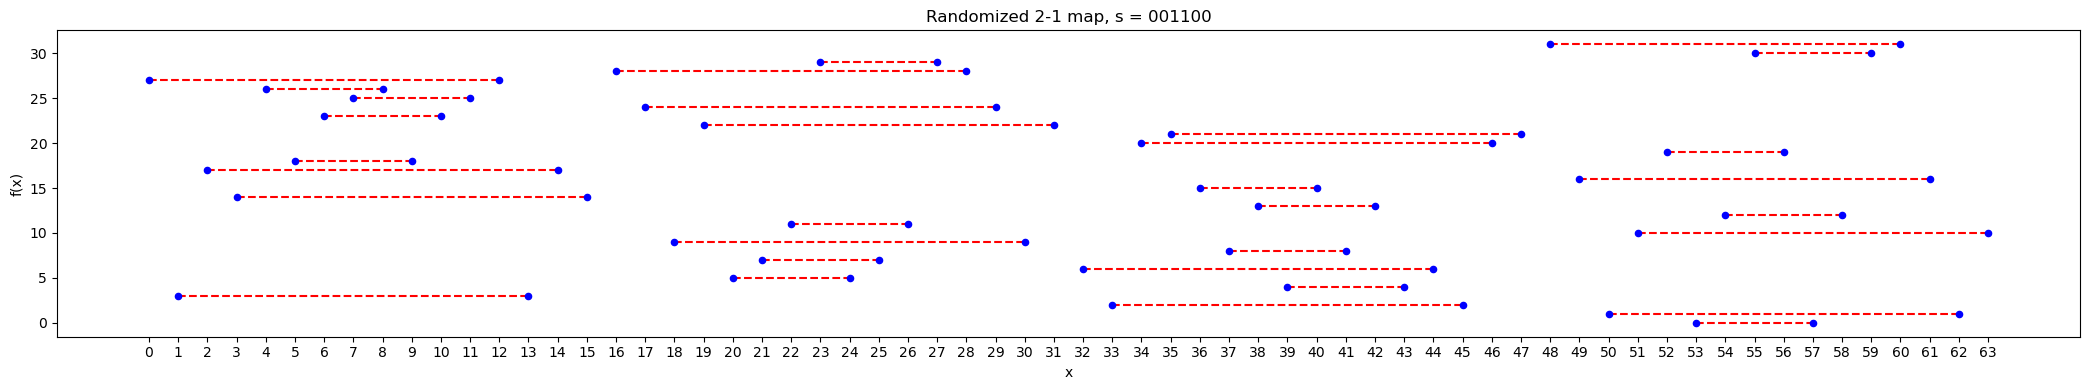

q0   -H--Uf---------------------------H--\Z/--------------------------
q1   -H--Uf---------------------------H-------\Z/---------------------
q2   -H--Uf---------------------------H------------\Z/----------------
q3   -H--Uf---------------------------H-----------------\Z/-----------
q4   -H--Uf---------------------------H----------------------\Z/------
q5   -H--Uf---------------------------H---------------------------\Z/-
q6   ----Uf--\Z/------------------------------------------------------
q7   ----Uf-------\Z/-------------------------------------------------
q8   ----Uf------------\Z/--------------------------------------------
q9   ----Uf-----------------\Z/---------------------------------------
q10  ----Uf----------------------\Z/----------------------------------



In [113]:
N = 6

s = np.random.randint(1, 2**N, dtype = np.uint8)
print(f"s = {s:0{N}b}")

x = np.arange(2**N)
x = x[x < (x ^ s)]  # eliminate redundancy over loop

y = np.arange(2**(N-1))
np.random.shuffle(y)

# generate a random 2-1 function that satisfies the criteria f(x) = f(x XOR s)
f = np.zeros(2**N, dtype = int)
for i in range(2**(N-1)):
    f[x[i]] = y[i]
    f[x[i] ^ s] = y[i]
plot_2to1_map(f, s)
Uf = Gate('Uf', simon_oracle(f), 2*N - 1)

c = Circuit(2*N - 1, 2*N - 1)
c.add_gate(HGate(N), np.arange(N))
c.add_gate(Uf, np.arange(2*N - 1))
for i in range(N-1):
    c.measure([N+i], [N+i])
c.add_gate(HGate(N), np.arange(N))
for i in range(N):
    c.measure([i], [i])
c.draw()

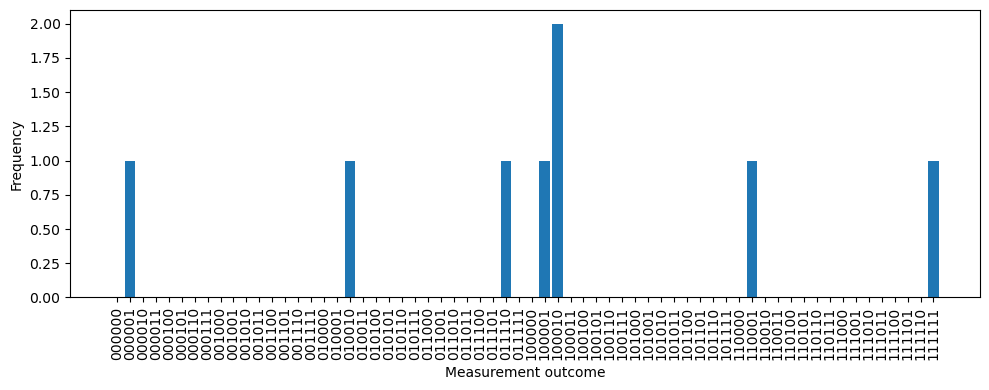

s = 001100


In [114]:
sim = Simulator(c)
outputs, frequencies = sim.run_measurements(N+2, cbits_idx = np.arange(N))
ints_out = bitrows_to_ints(np.unique(outputs, axis = 0))
solutions = gf2_nullspace(ints_out, N)
if len(solutions) > 1:
    print("Not enough linearly independent equations found in measurement. Increase the amount of iterations or run again.")
else:
    print(f"s = {solutions[0]:0{N}b}")
